In [2]:
import numpy as np

import scipy as sp
import scipy.constants

import matplotlib.pyplot as plt

import pandas as pd

import py3nj

%matplotlib inline
np.set_printoptions(precision=3,suppress=True)

In [3]:
def arange(val1, val2=None, ax=0):
    if val2 is None:
        val2 = -val1
    val_min = np.min([val1,val2])
    val_max = np.max([val1,val2])
    return np.arange(val_min, val_max+1, 1)

class am_basis():
    
    def __init__(self, cols=None, arr=None): 
        if arr is None:
            self.v = self.build_basis(cols)        
        else:
            self.v = pd.DataFrame(arr, columns=cols)
        self.set_vals()
        
    def build_basis(self, cols):    
        # cols contains list of lists
        # [['i_na', 3/2, 1], ['s_na', 1/2, 1]]        
        col_names = []
        grid_list = []    
        for c in cols:
            col_names.append(c[0])
            grid_list.append(c[1])        
            if c[2]:            
                col_names.append('m_'+c[0]) 
                gt = []
                c_f = c[1]
                if not isinstance(c[1], list):
                    c_f = [c[1]]                  
                for f in c_f:
                    gt.extend(arange(-f,f).tolist())
                grid_list.append(gt)

        grid_arr = np.meshgrid(*grid_list)

        n_col = len(col_names)
        n_row = grid_arr[0].size
        d_np = np.empty((n_row,n_col))        
        for i,g in enumerate(grid_arr):
            d_np[:,i] = g.flatten()

        df = pd.DataFrame(d_np,columns=col_names)
        for j in col_names:
            if 'm_'+j in col_names:
                df = df[(df['m_'+j]<=df[j]) & (df['m_'+j]>=-df[j])]
            df.drop_duplicates(inplace=True,ignore_index=True)
        
            
        return df # pd.DataFrame(d_np,columns=col_names)

    def set_vals(self):
        self.cols = self.v.columns.to_list()
        self.nrow = self.v.shape[0]
        self.ncol = self.v.shape[1]
        self.np = self.v.to_numpy()   
        self.v2 = (2*self.v).astype('int16')
        self.op = basic_ops(self)
        
    def get_cols(self):
        return self.v.columns.to_list()
        
    def disp(self):
        print(self.v)
        
def join_basis(b_list):
    col_names = []
    b_list_nrow = []
    for b in b_list:
        for c in b.cols:
            col_names.append(c) 
        b_list_nrow.append(range(b.nrow))
    
    g_ind = np.meshgrid(*b_list_nrow)
    b_concat = []
    for b,g in zip(b_list,g_ind):
        b_concat.append(b.np[g.flatten()])
    b_np = np.concatenate(b_concat, axis=1)
    return am_basis(col_names,b_np)

def truncate_basis(b, col, val, M):
    arr = b.v.loc[b.v[col]==val].to_numpy(dtype='float64',na_value=np.nan)
    b_trunc = am_basis(b.get_cols(), arr)
    return b_trunc, M[b.v[col]==val,:]

def b_op(f,b,is_py3nj,*arg):
    # can move this to class param to save runtime(?)
    x,y = np.meshgrid(range(0,b.nrow),range(0,b.nrow))
    x = np.reshape(x, (-1))
    y = np.reshape(y, (-1))
    
    if is_py3nj:
        bx = b.v2.iloc[x].reset_index(drop=True)
        by = b.v2.iloc[y].reset_index(drop=True)
        return np.reshape(f(bx,by,*arg),(b.nrow,b.nrow))
    else:
        bx = b.v.iloc[x].reset_index(drop=True)
        by = b.v.iloc[y].reset_index(drop=True)      
        return np.reshape(f(bx,by,*arg).to_numpy(),(b.nrow,b.nrow))
    
def sph_ops(b,j):
    _,_,delta_spec = get_spectators(b,[j,'m_'+j],mat=True)
    f1 = b_op(lambda b1,b2,j: (-1)**(b1[j]-b1['m_'+j]), b, 0,j)    
    f2 = b_op(lambda b1,b2,j: np.sqrt(b2[j]*(b2[j]+1)*(2*b2[j]+1)),b,0,j)
    delta_j = b_op(lambda b1,b2,j: b1[j]==b2[j],b,0,j)
    cg_z = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],    int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,0)
    cg_r1 = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],   int(2*1),   b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,1)
    cg_r2 = b_op(lambda b1,b2,j,q: py3nj.wigner3j(b1[j],       int(2*1), b2[j],
                                              -b1['m_'+j], int(2*q), b2['m_'+j]), b,1,j,-1)
    cg_y = 1j/2*np.sqrt(2) * (cg_r1+cg_r2)
    cg_x = 1/2*np.sqrt(2) * (cg_r2-cg_r1)

    M_z = delta_spec*f1*f2*delta_j*cg_z
    M_x = delta_spec*f1*f2*delta_j*cg_x
    M_y = delta_spec*f1*f2*delta_j*cg_y
    return (M_x,M_y,M_z)
    
def basic_ops(b):
    # find pairs
    op_dict = {};    
    cols = b.get_cols()
    
    # spherical terms
    j_list = []
    for c in cols:
        if 'm_'+c in cols:
            j_list.append(c)    
    for j in j_list:        
        jx,jy,jz = sph_ops(b,j)
        op_dict[j+'_x'] = jx
        op_dict[j+'_y'] = jy
        op_dict[j+'_z'] = jz
        op_dict[j+'^2'] = jx@jx + jy@jy + jz@jz

    # delta funcs
    for j in cols:
        op_dict['eq_'+j] = b_op(lambda b1,b2,j: b1[j]==b2[j],b,0,j)
        
    return op_dict

# parity operation
def par_op(f, b):
    return b_op(lambda b1,b2: (-1)**(f(b1,b2)), b, 0)        

def scal_op(f, b):
    return b_op(lambda b1,b2: f(b1,b2),b,0)

def dot_op(b, j1, j2):
    return np.real(b.op[j1+'_x']@b.op[j2+'_x']+b.op[j1+'_y']@b.op[j2+'_y']+b.op[j1+'_z']@b.op[j2+'_z'])  

def couple_basis_single(b,j1,j2,j):

    cols_ex = ['m_'+j1,'m_'+j2]
    cols_in = get_spectators(b,cols_ex)[1] + [j,'m_'+j]
    
    bv = b.v.drop(cols_ex, axis=1, inplace=False).drop_duplicates(inplace=False)
    b_concat = []
    for i,r in bv.iterrows():
        j_min = np.abs(r[j1]-r[j2])
        j_max = np.abs(r[j1]+r[j2])
        for jval in arange(j_min,j_max):
            jvals = np.atleast_2d(arange(jval)).T
            s = jvals.shape
            b_concat.append(np.concatenate([np.tile(np.array(r),s),jval*np.ones(s),jvals],axis=1))
            
    bc = am_basis(cols_in,np.concatenate(b_concat,axis=0))
    M = trans_matrix(b,bc,j1,j2,j)
    return (bc, M)

def trans_matrix(b1,b2,j1,j2,j):
    
    # transformation matrix from b1 (uncoupled) to b2 (coupled)
    x,y = np.meshgrid(range(0,b1.nrow),range(0,b1.nrow))
    x = np.reshape(x, (-1))
    y = np.reshape(y, (-1))
    
    bx = b1.v2.iloc[x].reset_index(drop=True)
    by = b2.v2.iloc[y].reset_index(drop=True)
    cg = py3nj.wigner3j(bx[j1],bx[j2],by[j],
                    bx['m_'+j1],bx['m_'+j2],-by['m_'+j])*np.sqrt(by[j]+1)

    # spectator columns
    b1_s = get_spectators(b1,['m_'+j1,'m_'+j2])[0].iloc[x].reset_index(drop=True)
    b2_s = get_spectators(b2,[j,'m_'+j])[0].iloc[y].reset_index(drop=True)
    del_spec = np.prod(np.equal(b1_s,b2_s),axis=1)
    
    return np.reshape(np.expand_dims(cg*del_spec,1),(b1.nrow,b1.nrow))                       


def couple_basis(b, j=None, j_list=None):
    if j:
        return couple_basis_single(b,*j)
    else:
        bc = b
        MM = None
        for jj in j_list:
            bc, M = couple_basis_single(bc,*jj)
            if MM is None:
                MM = M
            else:
                MM = M @ MM
        return bc, MM
        
def get_spectators(b,j_list,mat=False):
    cols = b.get_cols()
    for j in j_list:
        cols.remove(j)
    if mat:
        M = np.zeros([b.nrow,b.nrow])
        v_spec = b.v[cols].copy()
        for i,r in v_spec.iterrows():
            M[i,:] = np.prod(np.equal(v_spec, r), axis=1)  
        return (v_spec, cols, M)
    else:
        return (b.v[cols].copy(), cols)        


In [4]:
class consts():
    
    hbar = sp.constants.hbar
    h = sp.constants.h # m^2 kg s^-1 = J s
    
    muB = sp.constants.physical_constants["Bohr magneton"][0]  # J T^-1
    muN = sp.constants.physical_constants["neutron mag. mom."][0] # J T^-1
    
    ge = sp.constants.physical_constants["electron g factor"][0]

    gL = 0.99999369
    gS = 2.0023193043622
    gI = -0.0009951414

    A_hfs_d2 = 84.7185
    A_hfs_d1 = 407.25
    A_hfs_s = 3.417341305452145e3
c = consts()

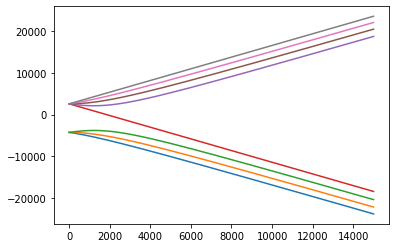

In [5]:
b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 0, 1]])

b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])

H_hf_uc = c.A_hfs_s * np.transpose(M_uc2jc)@dot_op(b_jc,'i','j')@M_uc2jc

B = np.linspace(0,15000,15000)*1e-4 # T
H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                  c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]

H_uc = H_hf_uc + H_Z_uc

E = np.linalg.eigvals(H_uc)
E = np.sort(E,axis=1)
fig = plt.plot(B*1e4,E)

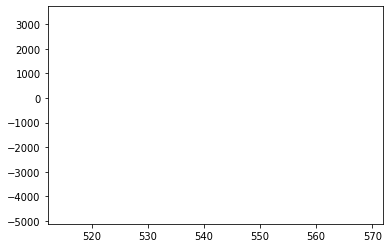

In [33]:
b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 0, 1]])

b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])

H_hf_uc = c.A_hfs_s * np.transpose(M_uc2jc)@dot_op(b_jc,'i','j')@M_uc2jc

B = np.linspace(542,542,1)*1e-4 # T
H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                  c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]

H_uc = H_hf_uc + H_Z_uc

E = np.linalg.eigvals(H_uc)
E = np.sort(E,axis=1)
fig = plt.plot(B*1e4,E)

In [34]:
def calc_eig(H):
    E0, Ev0 = np.linalg.eig(H)
    E0 = np.real(E0)
    
#     if Ev0.shape[0] == 1:
#         Ev0 = np.squeeze(Ev0)      
#     else:
    print('hello')
    sort_ind = np.argsort(E0,axis=1)
    E0 = np.take_along_axis(E0,sort_ind,axis=1)
    Ev0 = np.take_along_axis(Ev0,sort_ind[:,None,:],axis=2)
    return E0, Ev0
E, Ev = calc_eig(H_uc)

hello


In [35]:
Ev.shape

(1, 8, 8)

In [36]:
E

array([[-4708.955, -4355.135, -3961.461,  1804.662,  2254.3  ,  2646.464,
         2998.775,  3321.35 ]])

In [38]:
Ev

array([[[ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.808,  0.   , -0.589,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.589,  0.   ,  0.808,  0.   ,  0.   ,  0.   ],
        [ 0.   , -0.626,  0.   ,  0.   ,  0.   , -0.78 ,  0.   ,  0.   ],
        [ 0.   , -0.78 ,  0.   ,  0.   ,  0.   ,  0.626,  0.   ,  0.   ],
        [-0.424,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.906,  0.   ],
        [-0.906,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.424,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ]]])

In [10]:
b_uc.disp()

     i  m_i    s  m_s    l  m_l
0  1.5 -1.5  0.5 -0.5  0.0  0.0
1  1.5 -1.5  0.5  0.5  0.0  0.0
2  1.5 -0.5  0.5 -0.5  0.0  0.0
3  1.5 -0.5  0.5  0.5  0.0  0.0
4  1.5  0.5  0.5 -0.5  0.0  0.0
5  1.5  0.5  0.5  0.5  0.0  0.0
6  1.5  1.5  0.5 -0.5  0.0  0.0
7  1.5  1.5  0.5  0.5  0.0  0.0


In [81]:
M_uc2jc[b_jc.v['j']==1/2]

array([[ 0.   ,  0.577,  0.   , -0.816,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.816,  0.   ,  0.577,  0.   ,  0.   ,  0.   ,
        -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.577,
         0.   , -0.816,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.816,  0.   ,  0.577,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.577,  0. 

In [76]:
M_uc2jc[b_jc.v['j']==1/2][:,b_jc.v['j']==1/2]

array([[0.   , 0.577, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.577, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.577, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.577],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

In [67]:
b_jc_d2.disp()

      i  m_i    s    l    j  m_j
0   1.5 -1.5  0.5  1.0  1.5 -1.5
1   1.5 -1.5  0.5  1.0  1.5 -0.5
2   1.5 -1.5  0.5  1.0  1.5  0.5
3   1.5 -1.5  0.5  1.0  1.5  1.5
4   1.5 -0.5  0.5  1.0  1.5 -1.5
5   1.5 -0.5  0.5  1.0  1.5 -0.5
6   1.5 -0.5  0.5  1.0  1.5  0.5
7   1.5 -0.5  0.5  1.0  1.5  1.5
8   1.5  0.5  0.5  1.0  1.5 -1.5
9   1.5  0.5  0.5  1.0  1.5 -0.5
10  1.5  0.5  0.5  1.0  1.5  0.5
11  1.5  0.5  0.5  1.0  1.5  1.5
12  1.5  1.5  0.5  1.0  1.5 -1.5
13  1.5  1.5  0.5  1.0  1.5 -0.5
14  1.5  1.5  0.5  1.0  1.5  0.5
15  1.5  1.5  0.5  1.0  1.5  1.5


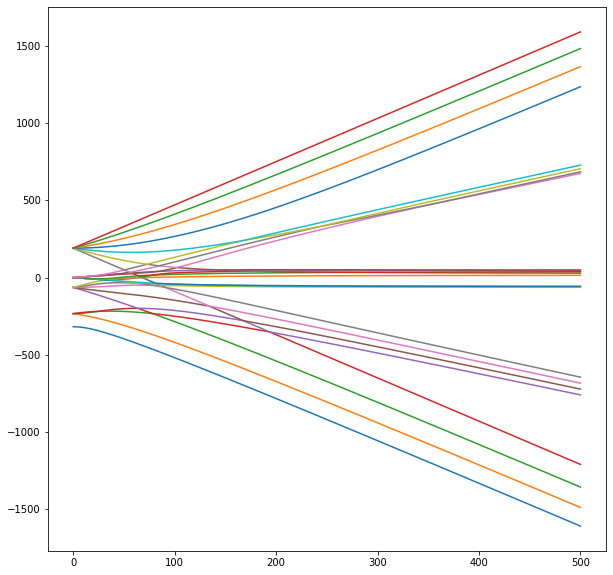

In [89]:
b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 1, 1]])

b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])
b_jc_d2, M_uc2jcd2 = truncate_basis(b_jc, 'j', 3/2, M_uc2jc)

H_hf_uc = c.A_hfs_d2 * np.transpose(M_uc2jcd2)@dot_op(b_jc_d2,'i','j')@M_uc2jcd2

B = np.linspace(0,500,500)*1e-4 # T
H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                  c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]

H_uc = H_hf_uc + H_Z_uc

E = np.linalg.eigvals(H_uc)
E = np.sort(E,axis=1)
plt.figure(1,figsize=(10,10))
fig = plt.plot(B*1e4,E)

In [87]:
H_hf_uc = c.A_hfs_d2 * np.transpose(M_uc2jcd2)@dot_op(b_jc_d2,'i','j')@M_uc2jcd2


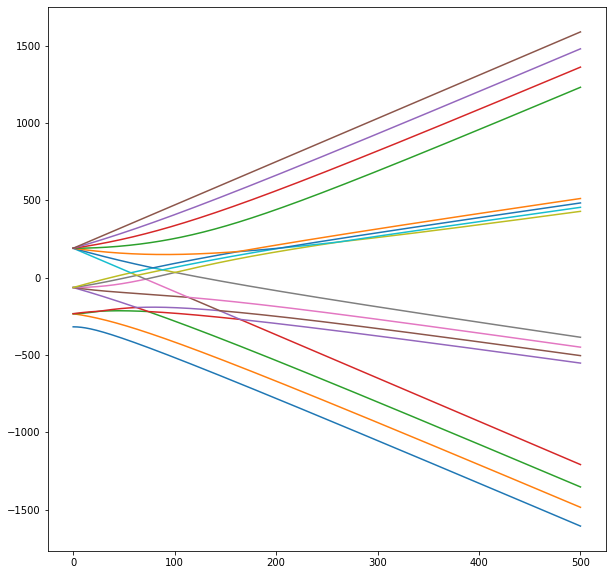

In [90]:
b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 1, 1]])

b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])
b_jc_d2, M_uc2jcd2 = truncate_basis(b_jc, 'j', 3/2, M_uc2jc)

H_hf_jc = c.A_hfs_d2 * dot_op(b_jc_d2,'i','j')

B = np.linspace(0,500,500)*1e-4 # T
H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                  c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]
H_Z_jc = M_uc2jcd2@H_Z_uc@np.transpose(M_uc2jcd2)

H_jc = H_hf_jc + H_Z_jc

E = np.linalg.eigvals(H_jc)
E = np.sort(E,axis=1)
plt.figure(1,figsize=(10,10))
fig = plt.plot(B*1e4,E)

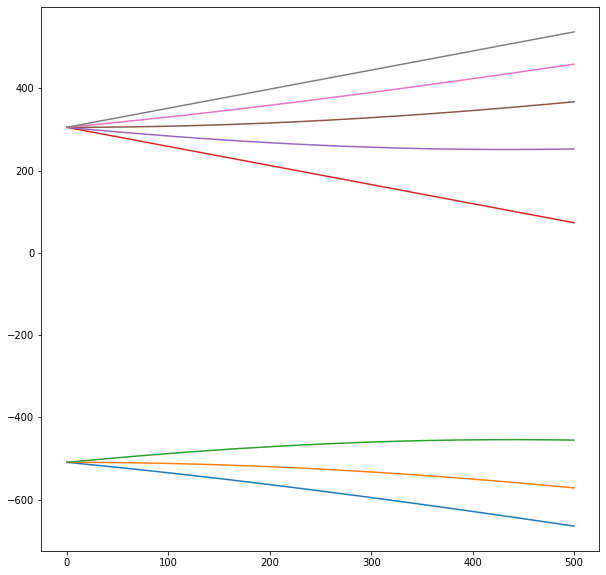

In [113]:
b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 1, 1]])

b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])
b_jc_d1, M_uc2jcd1 = truncate_basis(b_jc, 'j', 1/2, M_uc2jc)

H_hf_jc = c.A_hfs_d1 * dot_op(b_jc_d1,'i','j')

B = np.linspace(0,500,500)*1e-4 # T
H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                  c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]
H_Z_jc = M_uc2jcd1@H_Z_uc@np.transpose(M_uc2jcd1)

H_jc = H_hf_jc + H_Z_jc

E = np.linalg.eigvals(H_jc)
E = np.sort(E,axis=1)
plt.figure(1,figsize=(10,10))
fig = plt.plot(B*1e4,E)

In [94]:
b_jc_d1.disp()

     i  m_i    s    l    j  m_j
0  1.5 -1.5  0.5  1.0  0.5 -0.5
1  1.5 -1.5  0.5  1.0  0.5  0.5
2  1.5 -0.5  0.5  1.0  0.5 -0.5
3  1.5 -0.5  0.5  1.0  0.5  0.5
4  1.5  0.5  0.5  1.0  0.5 -0.5
5  1.5  0.5  0.5  1.0  0.5  0.5
6  1.5  1.5  0.5  1.0  0.5 -0.5
7  1.5  1.5  0.5  1.0  0.5  0.5


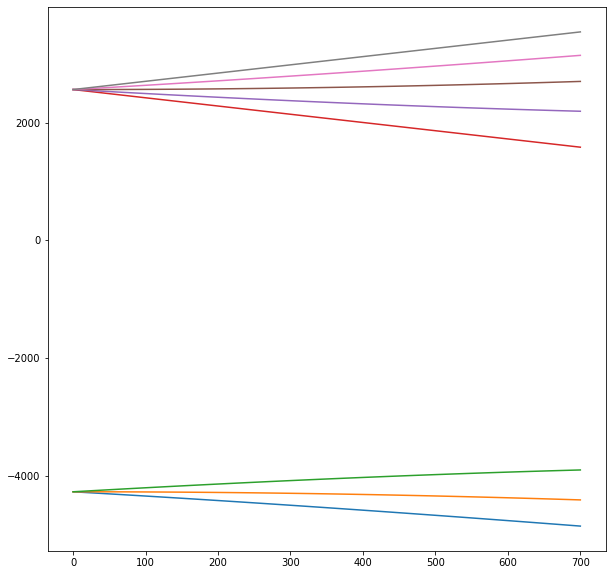

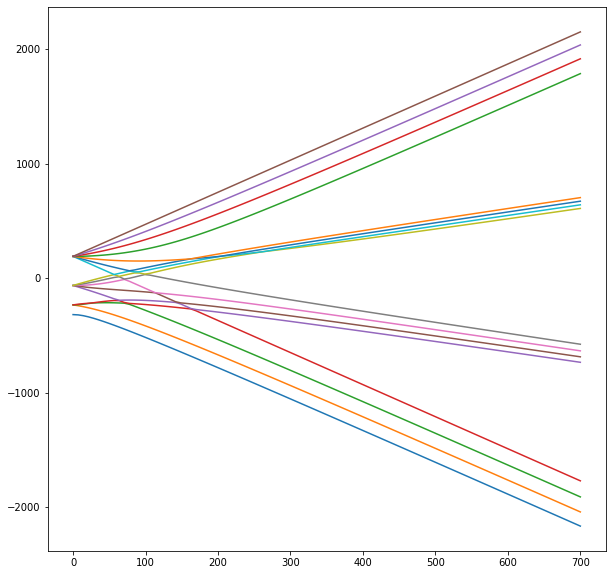

In [121]:

def calc_hfE(s,Bs):
    B = np.linspace(Bs[0],Bs[1],Bs[2])*1e-4
    if s == 's':
        b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 0, 1]])
        b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])

        H_hf_uc = c.A_hfs_s * np.transpose(M_uc2jc)@dot_op(b_jc,'i','j')@M_uc2jc
        H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                          c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]
        H_uc = H_hf_uc + H_Z_uc

        E = np.linalg.eigvals(H_uc)
        E = np.sort(E,axis=1)
    elif s == 'd2':  
        
        b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 1, 1]])
        b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])
        b_jc_d2, M_uc2jcd2 = truncate_basis(b_jc, 'j', 3/2, M_uc2jc)

        H_hf_jc = c.A_hfs_d2 * dot_op(b_jc_d2,'i','j')
        H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                          c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]
        H_Z_jc = M_uc2jcd2@H_Z_uc@np.transpose(M_uc2jcd2)

        H_jc = H_hf_jc + H_Z_jc

        E = np.linalg.eigvals(H_jc)
        E = np.sort(E,axis=1)
    elif s == 'd1':
        b_uc = am_basis([['i', 3/2, 1], ['s', 1/2, 1], ['l', 1, 1]])
        b_jc, M_uc2jc = couple_basis(b_uc,['l','s','j'])
        b_jc_d1, M_uc2jcd1 = truncate_basis(b_jc, 'j', 1/2, M_uc2jc)

        H_hf_jc = c.A_hfs_d1 * dot_op(b_jc_d1,'i','j')

        H_Z_uc = c.muB * (c.gS*b_uc.op['s_z'] + c.gI*b_uc.op['i_z'] +
                          c.gL*b_uc.op['l_z']) / c.h / 1e6 * B[:, np.newaxis, np.newaxis]
        H_Z_jc = M_uc2jcd1@H_Z_uc@np.transpose(M_uc2jcd1)

        H_jc = H_hf_jc + H_Z_jc

        E = np.linalg.eigvals(H_jc)
        E = np.sort(E,axis=1)
    else:
        E = 0
    
    return E, B*1e4
        
E_s,B_s = calc_hfE('s',[0,700,100])
E_d2,B_d2 = calc_hfE('d2',[0,700,100])        
        
plt.figure(1,figsize=(10,10))

plt.plot(B_s,E_s)
plt.figure(2,figsize=(10,10))
plt.plot(B_d2,E_d2)

In [108]:
E_d2.shape

(2, 16)

In [116]:
E_d2[1,-1]-E_d2[0,-1]

195.91417977345577

In [115]:
E_s[1,-1]-E_s[0,-1]

97.94108343508606

In [131]:
E_s,B_s = calc_hfE('s',[492,542,2])
E_d2,B_d2 = calc_hfE('d2',[492,542,2])

E_d2[1,-1]-E_d2[0,-1]-(E_s[1,-1]-E_s[0,-1])

69.98078309883567

In [132]:
B_s

array([492., 542.])

In [133]:
E_s,B_s = calc_hfE('d2',[0,100,2])


In [128]:
E_s.shape

(3, 16)

In [129]:
E_s[2,-1]-E_s[1,-1]

758.4677531229505

In [130]:
E_s[1,-1]-E_s[0,-1]

758.4677531229505

In [136]:
E_s[1,-1]-E_s[0,-1]

279.8773996763655